In [7]:
%matplotlib inline
import torch
import math
import time
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

这行代码 ```%matplotlib inline``` 是 Jupyter Notebook 或 JupyterLab 中的一个魔术命令，用于指示 Notebook 在单元格中直接显示 Matplotlib 绘制的图形，而不是弹出一个新窗口显示图形。这使得图形能够直接嵌入到 Notebooks 中，并且在导出 Notebook 时也能够保留图形。

# 线性神经网路

## 线性回归

### 矢量化加速
    这个非常重要

In [45]:
# 定义一个计时器
class Timer:
    '''记录多次运行的时间'''
    def __init__(self) -> None:
        self.times = []
        # 从定义这个计时器就开始计时
        self.start()
        
    def start(self):
        '''启动计时器'''
        self.tik = time.time()

    def stop(self):
        '''停止计时器并将时间记录在列表中'''
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        '''返回平均时间'''
        return sum(self.times) / len(self.times)
    
    def sum(self):
        '''返回时间总和'''
        return sum(self.times)
    
    def cumsum(self):
        '''返回累计时间'''
        return np.array(self.times).cumsum().tolist()


In [70]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = a[i] + b[i]
print(f'遍历的方法：{timer.stop():.6f} sec')

timer.start()
d = a + b
print(f'矢量化方法：{timer.stop():.6f} sec')

遍历的方法：0.119986 sec
矢量化方法：0.000000 sec


### 正态分布与平方损失

In [71]:
# 定义一个正态分布
def normal(x, mu, sigma):
    '''正太分布密度函数'''
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

## 线性回归从0开始

In [2]:
import random 
import torch
from d2l import torch as d2l

### 1.生成数据

In [3]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    # matmul将X与w相乘
    y = torch.matmul(X, w) + b
    # 向生成的数据中加入随机扰动项
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

# 生成数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

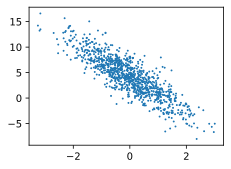

In [4]:
# 绘制图像
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

### 2.读取数据集

In [13]:
def data_iter(batch_size, features, labels):
    '''生成小批量'''
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break  # 只输出一个看看

tensor([[-0.9580, -0.6944],
        [ 0.8011, -1.5581],
        [-1.6484, -1.2417],
        [-0.0216, -0.0073],
        [-0.9783, -1.7027],
        [ 0.2998,  0.4365],
        [ 0.1407,  0.1178],
        [ 0.6220, -0.2995],
        [ 0.6070, -0.5613],
        [-0.9565, -0.4306]]) 
 tensor([[ 4.6380],
        [11.0916],
        [ 5.1280],
        [ 4.1803],
        [ 8.0655],
        [ 3.3188],
        [ 4.0847],
        [ 6.4579],
        [ 7.3332],
        [ 3.7468]])


### 3.初始化模型参数

In [46]:
# 初始化权重
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0193],
         [-0.0045]], requires_grad=True),
 tensor([0.], requires_grad=True))

### 4.定义模型

In [48]:
def linreg(X, w, b):
    '''线性回归模型'''
    return torch.matmul(X, w) + b

### 5.定义损失函数

In [49]:
def squared_loss(y_hat, y):
    '''均方损失'''
    # y_hat是预测值
    return (y_hat - y.reshape(y_hat.shape)) ** 2/2

### 6.定义优化算法

In [ ]:
# 这里使用的是小批量随机梯度下降
def sgd(params, lr, batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad:
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 7.训练

In [ ]:
lr = 0.03
num_epochs = 3
# 下面这样设置形式，后面方便换成需要的模型
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)